[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


sigma 0.20727871611179066
             putprice  callprice  Open  High   Low  Close  Adj Close  Volume
Date                                                                        
2024-11-25  21.584987   0.813679  0.45  0.45  0.22   0.22       0.22      78
2024-11-26  19.651343   1.035289  0.42  0.45  0.30   0.45       0.45      74
2024-11-27  19.750507   0.969696  0.45  0.51  0.39   0.50       0.50      86
2024-11-29  17.655761   1.205439  0.37  0.63  0.37   0.59       0.59     513
2024-12-02  15.695108   1.400466  0.65  0.93  0.65   0.72       0.72     634
Option Greeks:
Delta_Call: 0.5510315555073384
Delta_Put: -0.4489684444926616
Gamma: 0.05393072546358658
Vega: 14.005023805954552
Theta_Call: -82.55787886017345
Theta_Put: -69.82009902764993
Rho_Call: 2.636602191056578
Rho_Put: -2.2491215803223037


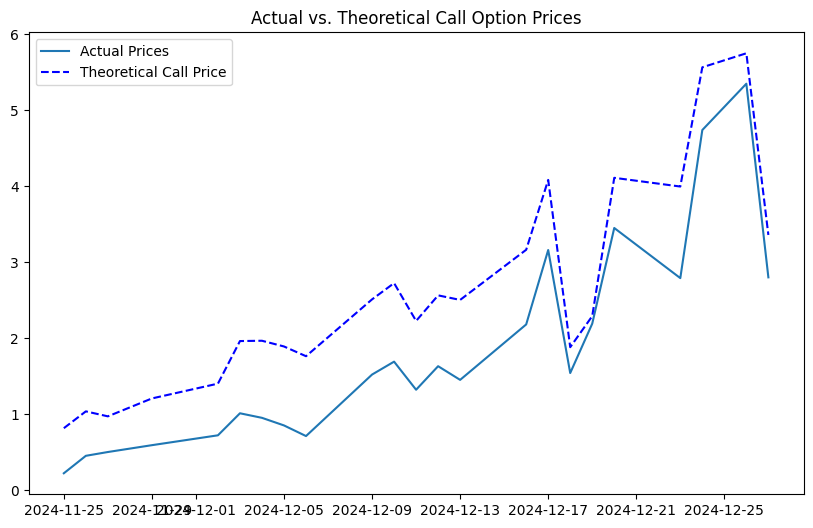

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt

# Black-Scholes Formula
def black_scholes(S, K, T, r, sigma, option_type="call"):
    d1 = (np.log(S / K) + (r + (sigma**2) / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Option Greeks
def calculate_greeks(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + (sigma**2) / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    delta_call = norm.cdf(d1)
    delta_put = -norm.cdf(-d1)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T)
    theta_call = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))) - (r * K * np.exp(-r * T) * norm.cdf(d2))
    theta_put = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))) + (r * K * np.exp(-r * T) * norm.cdf(-d2))
    rho_call = K * T * np.exp(-r * T) * norm.cdf(d2)
    rho_put = -K * T * np.exp(-r * T) * norm.cdf(-d2)
    
    return {
        "Delta_Call": delta_call, "Delta_Put": delta_put,
        "Gamma": gamma, "Vega": vega,
        "Theta_Call": theta_call, "Theta_Put": theta_put,
        "Rho_Call": rho_call, "Rho_Put": rho_put
    }

# Fetch historical data from Yahoo Finance
symbol = "AAPL"
data = yf.download(symbol, period="6mo")
data["Returns"] = np.log(data["Adj Close"] / data["Adj Close"].shift(1))
sigma = data["Returns"].std() * np.sqrt(252)  # Annualized volatility
print("sigma", sigma)
S = data["Adj Close"].iloc[-1]  # Current stock price
r = 0.05  # Risk-free rate (assumed)
T = 7 / 365  # Time to expiration (30 days)
K = 255.0  # Strike price(Taking it as 255)
# Calculate theoretical call and put prices
greeks = calculate_greeks(S, K, T, r, sigma)

symbol = "AAPL250103C00255000"
data_option = yf.download(symbol, period="max")

data_option.insert(0, "callprice", 0.0)
data_option.insert(0, "putprice", 0.0)

dt = pd.to_datetime('2025/01/03', format='%Y/%m/%d')
for i in range(0, len(data_option)):
    S=data.loc[data_option.index[i], "Adj Close"]
    t=dt-data_option.index[i]
    T= t.days/365
    data_option.loc[data_option.index[i], "callprice"]=black_scholes(S, K, T, r, sigma, "call")
    data_option.loc[data_option.index[i], "putprice"]=black_scholes(S, K, T, r, sigma, "put")


print(data_option.head(5))

# Output results
print("Option Greeks:")
for greek, value in greeks.items():
    print(f"{greek}: {value}")



# Plot theoretical option prices
plt.figure(figsize=(10, 6))
plt.plot(data_option["Adj Close"], label="Actual Prices")
plt.plot(data_option["callprice"], color="blue", linestyle="--", label="Theoretical Call Price")
plt.title("Actual vs. Theoretical Call Option Prices")
plt.legend()
plt.show()
